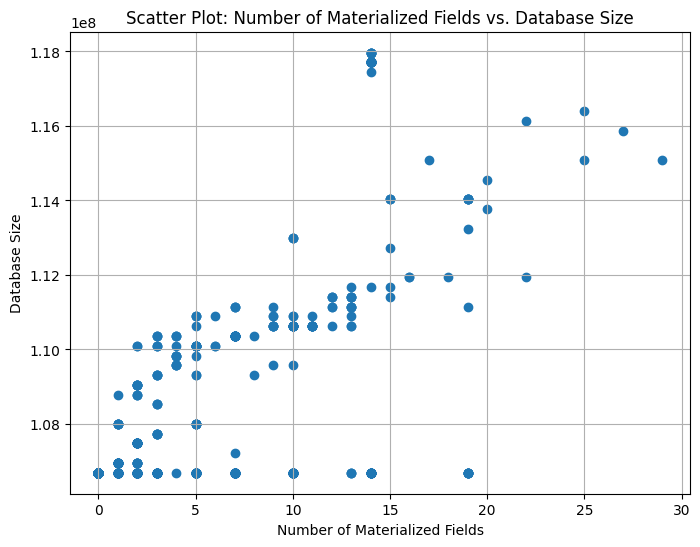

In [2]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Small dataset, 500 queries - old
# RESULTS_PATH = "../results/tpch/2025-03-06-9H"
# Small dataset, 500 queries - new
RESULTS_PATH = "../results/tpch/2025-03-11-17H"
# Small dataset, 100 queries
# RESULTS_PATH = "../results/tpch/2025-03-10-14H"
# Small dataset, 500 queries (fewer param permutations)
# RESULTS_PATH = "../results/tpch/2025-03-05-15H"

# Read the CSV file
meta_results = pd.read_csv(RESULTS_PATH + "/meta_results.csv")

# Function to count the number of materialized fields from the string representation
def count_materialized_fields(s: str):
    try:
        # Converts the string representation to a python list
        fields = ast.literal_eval(s)
        return len(fields)
    except Exception as e:
        print(e)

# Create a new column with the number of materialized fields
meta_results["num_materialized_fields"] = meta_results["Materialization"].apply(count_materialized_fields)


# Exclude rows where Test is full_materialization
meta_results_no_full = meta_results[meta_results["Test"] != "full_materialization"]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(meta_results_no_full["num_materialized_fields"], meta_results_no_full["Database size"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Database Size")
plt.title("Scatter Plot: Number of Materialized Fields vs. Database Size")
plt.grid(True)
plt.show()


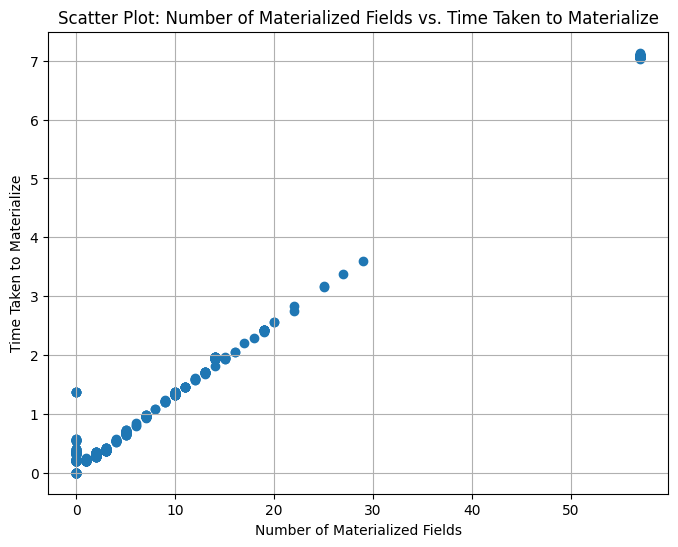

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(meta_results["num_materialized_fields"], meta_results["Time to prepare db"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Time Taken to Materialize")
plt.title("Scatter Plot: Number of Materialized Fields vs. Time Taken to Materialize")
plt.grid(True)
plt.show()

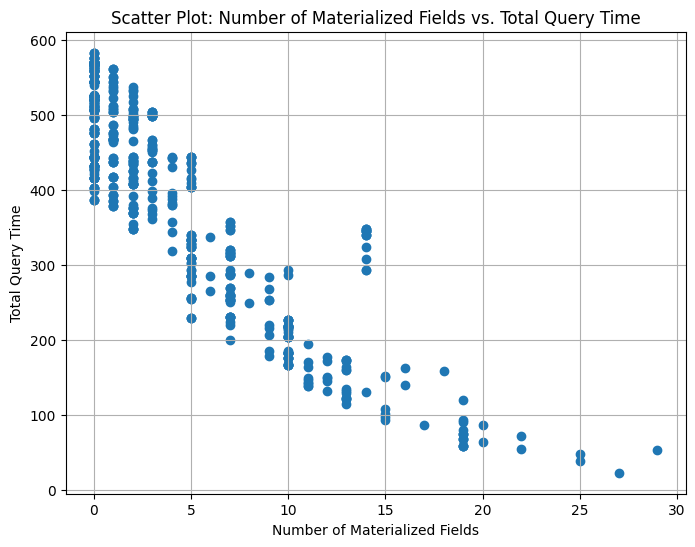

In [4]:
subset = meta_results[(meta_results["Total query time"] > 0) & (meta_results["Test"] != "full_materialization") & (meta_results["Test"] != "schema_based_materialization")]
plt.figure(figsize=(8, 6))
plt.scatter(subset["num_materialized_fields"], subset["Total query time"])
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Total Query Time")
plt.title("Scatter Plot: Number of Materialized Fields vs. Total Query Time")
plt.grid(True)
plt.show()

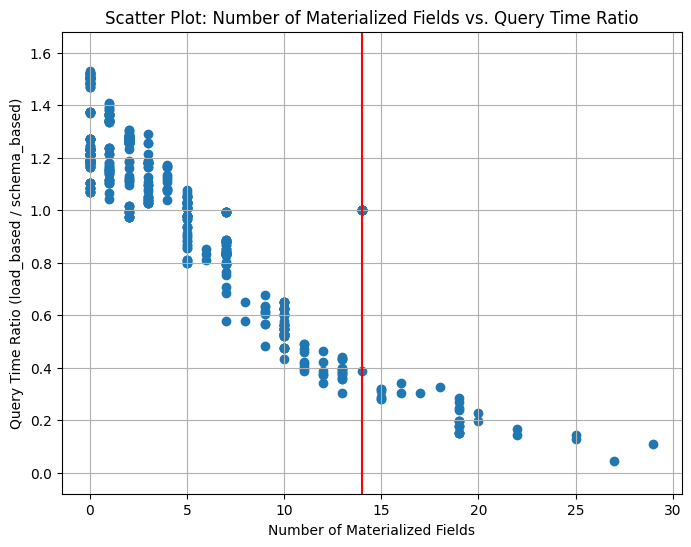

In [5]:
subset = meta_results[(meta_results["Total query time"] > 0)]
# Subset rows where Test starts with "load_based_t"
load_based = subset[subset["Test"].str.startswith("load_based_t")]

# Subset rows with Test equal to "schema_based_materialization"
schema_based = subset[subset["Test"] == "schema_based_materialization"]

# Merge the two dataframes on the columns "Query proportion", "Majority proportion", and "Load"
merged = pd.merge(
    load_based,
    schema_based,
    on=["Query proportion", "Majority proportion", "Load"],
    suffixes=('_load', '_schema')
)
# Compute the ratio between the total query time of the load_based row and the corresponding schema_based row
merged["query_time_ratio"] = merged["Total query time_load"] / merged["Total query time_schema"]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged["num_materialized_fields_load"], merged["query_time_ratio"])
plt.axline([14, 0], [14, 1.6], color='red')
plt.xlabel("Number of Materialized Fields")
plt.ylabel("Query Time Ratio (load_based / schema_based)")
plt.title("Scatter Plot: Number of Materialized Fields vs. Query Time Ratio")
plt.grid(True)
plt.show()


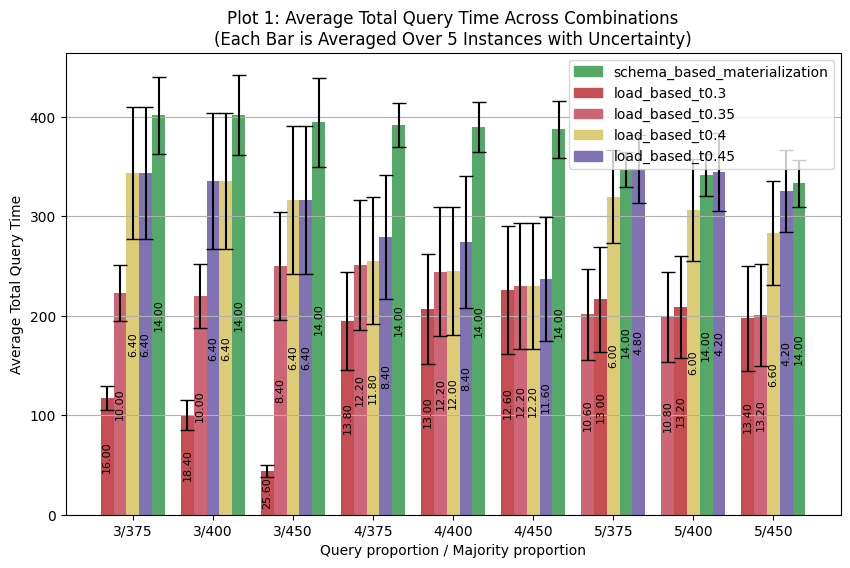

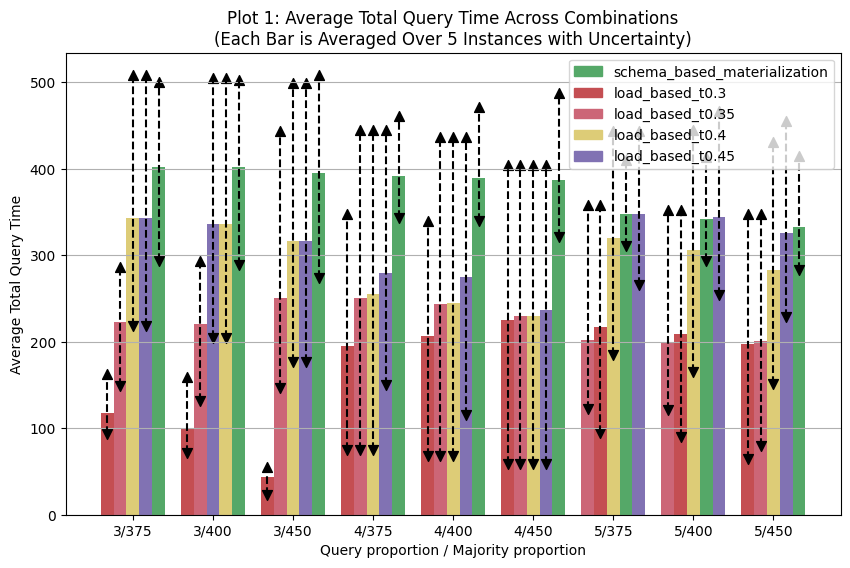

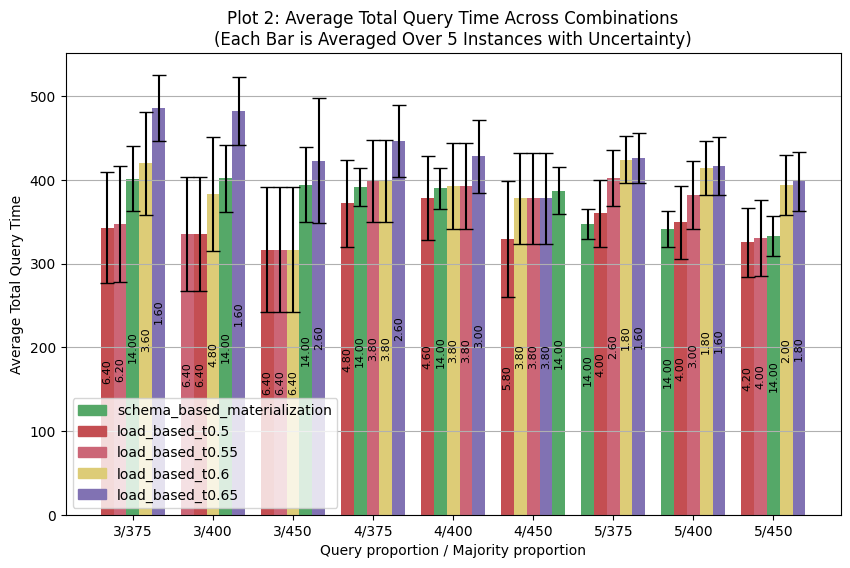

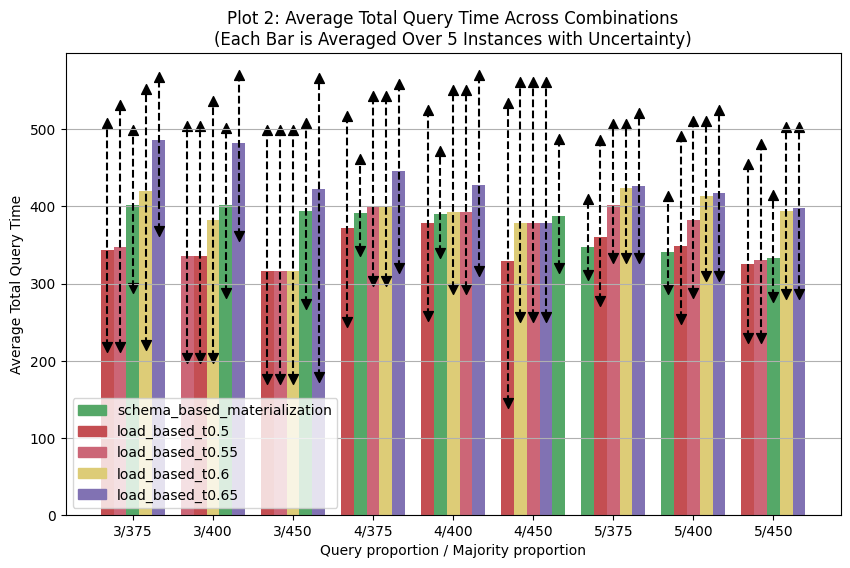

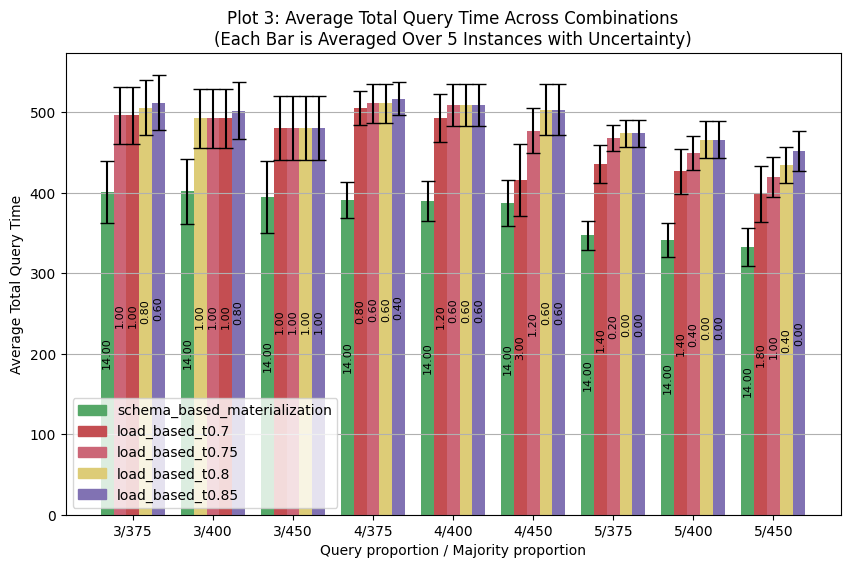

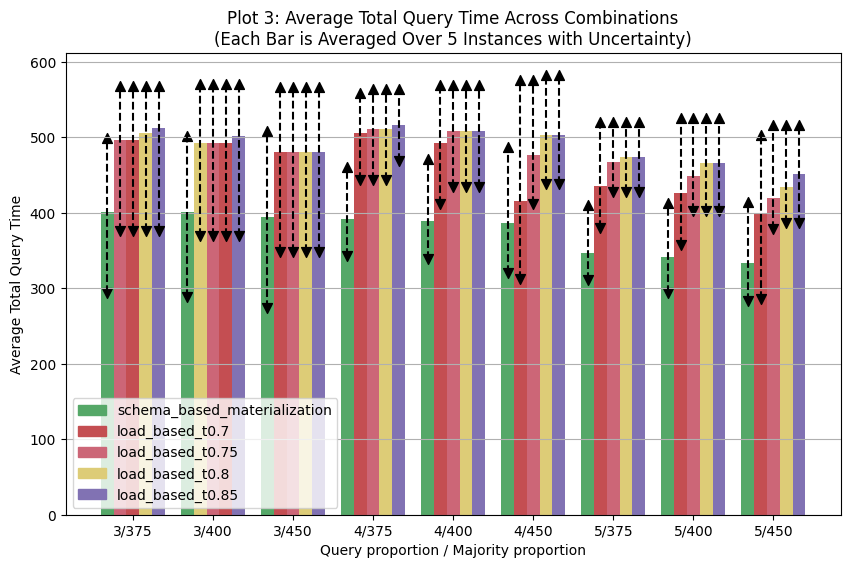

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Define color mapping for all tests (adjust the colors as needed)
colors = {
    "schema_based_materialization": "#55A868",
    "load_based_t0.3": "#C44E52",
    "load_based_t0.35": "#CC6677",   
    "load_based_t0.4": "#DDCC77",
    "load_based_t0.45": "#8172B3",
    "load_based_t0.5": "#C44E52",
    "load_based_t0.55": "#CC6677",
    "load_based_t0.6": "#DDCC77",
    "load_based_t0.65": "#8172B3",
    "load_based_t0.7": "#C44E52",
    "load_based_t0.75": "#CC6677",
    "load_based_t0.8": "#DDCC77",
    "load_based_t0.85": "#8172B3",
}

# Define test groups for the three plots
plot_tests = {
    1: ["schema_based_materialization", "load_based_t0.3", "load_based_t0.35", "load_based_t0.4", "load_based_t0.45"],
    2: ["schema_based_materialization", "load_based_t0.5", "load_based_t0.55", "load_based_t0.6", "load_based_t0.65"],
    3: ["schema_based_materialization", "load_based_t0.7", "load_based_t0.75", "load_based_t0.8", "load_based_t0.85"],
}

# Loop over each plot group and generate a separate figure
for plot_num, tests in plot_tests.items():
    # Filter the DataFrame for the tests in the current group.
    df_current = meta_results[meta_results["Test"].isin(tests)].copy()
    
    # Create a new column for combination (Query proportion / Majority proportion)
    df_current["combination"] = df_current["Query proportion"].astype(str) + "/" + df_current["Majority proportion"].astype(str)
    
    # Group by combination and Test to compute mean, standard deviation, and count.
    grouped_total_query_time = df_current.groupby(["combination", "Test"])["Total query time"] \
                        .agg(mean="mean", std="std", count="count", max="max", min="min").reset_index()
    
    grouped_total_query_time["stderr"] = grouped_total_query_time["std"] / np.sqrt(grouped_total_query_time["count"])
    
    grouped_num_mat_fields = df_current.groupby(["combination", "Test"])["num_materialized_fields"] \
                        .agg(mean_num_mat_fields="mean", std_num_mat_fields="std").reset_index()
    
    merged_pd = pd.merge(grouped_total_query_time, grouped_num_mat_fields, on=["combination", "Test"])
    

    
    # Pivot the DataFrames for means and standard errors
    pivot_df = grouped_total_query_time.pivot(index="combination", columns="Test", values="mean").sort_index()
    stderr_df = grouped_total_query_time.pivot(index="combination", columns="Test", values="stderr").sort_index()

    max_df = grouped_total_query_time.pivot(index="combination", columns="Test", values="max").sort_index()
    min_df = grouped_total_query_time.pivot(index="combination", columns="Test", values="min").sort_index()

    num_mat_fields_df = grouped_num_mat_fields.pivot(index="combination", columns="Test", values="mean_num_mat_fields").sort_index()


    for plot_i in range(2):
        # Create a new figure for the current plot
        # TODO Handle the two versions of the plot by using a loop
        fig, ax = plt.subplots(figsize=(10, 6))
        combinations_sorted = pivot_df.index.values
        x = np.arange(len(combinations_sorted))
        # Dynamically set bar width based on the number of tests in this group.
        bar_width = 0.8 / len(tests)
        
        # Loop over each combination and plot the bars with error bars.
        for i, comb in enumerate(combinations_sorted):
            # Get the data for the current combination (some tests might be missing).
            group_means = pivot_df.loc[comb].dropna()
            group_stderr = stderr_df.loc[comb].dropna()
            group_max = max_df.loc[comb].dropna()
            group_min = min_df.loc[comb].dropna()
            group_num_mat_fields = num_mat_fields_df.loc[comb].dropna()
            
            # Sort tests by average total query time (ascending)
            sorted_group = group_means.sort_values()
            sorted_stderr = group_stderr[sorted_group.index]
            sorted_max = group_max[sorted_group.index]
            sorted_min = group_min[sorted_group.index]
            sorted_num_mat_fields = group_num_mat_fields[sorted_group.index]
            
            # Plot each bar for the sorted tests
            for j, test in enumerate(sorted_group.index):
                # Compute the x position for this bar.
                bar_x = x[i] + j * bar_width

                if plot_i == 0:
                    # Plot the bar with the standard error as error bars.
                    ax.bar(bar_x, sorted_group[test], bar_width, color=colors[test],
                        yerr=sorted_stderr[test], capsize=5)

                    # Add annotation for the average number of materialized fields inside the bar.
                    # The text is rotated 90 degrees and centered within the bar.
                    text_value = f"{sorted_num_mat_fields[test]:.2f}"
                    ax.text(bar_x, sorted_group[test] / 2, text_value,
                            rotation=90, ha='center', va='center', fontsize=8, color="black")
                else:
                    ax.bar(bar_x, sorted_group[test], bar_width, color=colors[test], capsize=5)
                
                    # Plot a dashed line from min to max for the current test.
                    ax.plot([bar_x, bar_x],
                            [sorted_min[test], sorted_max[test]],
                            linestyle="--", color="black", linewidth=1.5)

                    # Add markers at the min and max values.
                    ax.scatter([bar_x], [sorted_min[test]], color="black", marker="v", s=50)
                    ax.scatter([bar_x], [sorted_max[test]], color="black", marker="^", s=50)
                    
        
        if plot_i == 0:
            # Set x-tick labels centered under each combination group.
            ax.set_xticks(x + bar_width * (len(tests) - 1) / 2)
            ax.set_xticklabels(combinations_sorted)
            ax.set_xlabel("Query proportion / Majority proportion")
            ax.set_ylabel("Average Total Query Time")
            ax.set_title(f"Plot {plot_num}: Average Total Query Time Across Combinations\n(Each Bar is Averaged Over 5 Instances with Uncertainty)")
            ax.grid(True, axis='y')

        else:
            # Set x-tick labels centered under each combination group.
            ax.set_xticks(x + bar_width * (len(tests) - 1) / 2)
            ax.set_xticklabels(combinations_sorted)
            ax.set_xlabel("Query proportion / Majority proportion")
            ax.set_ylabel("Average Total Query Time")
            ax.set_title(f"Plot {plot_num}: Average Total Query Time Across Combinations\n(Each Bar is Averaged Over 5 Instances with Uncertainty)")
            ax.grid(True, axis='y')
        
        # Create a custom legend using the tests defined for this plot.
        legend_handles = [mpatches.Patch(color=colors[test], label=test) for test in tests]
        ax.legend(handles=legend_handles)
        
        plt.show()

     Query proportion  Majority proportion  Load  Treshold  \
302                 4                  400     0       NaN   
303                 4                  400     0      0.30   
304                 4                  400     0      0.35   
305                 4                  400     0      0.40   
306                 4                  400     0      0.45   

                             Test  Time to prepare db  Total query time  \
302  schema_based_materialization            1.950506        471.598729   
303               load_based_t0.3            1.927580        150.520480   
304              load_based_t0.35            1.696764        171.644124   
305               load_based_t0.4            1.587938        176.991709   
306              load_based_t0.45            0.685542        427.206799   

     Blocks used  Block size  Database size  Materialized Columns  \
302          449      262144      117702656                    14   
303          426      262144      1116

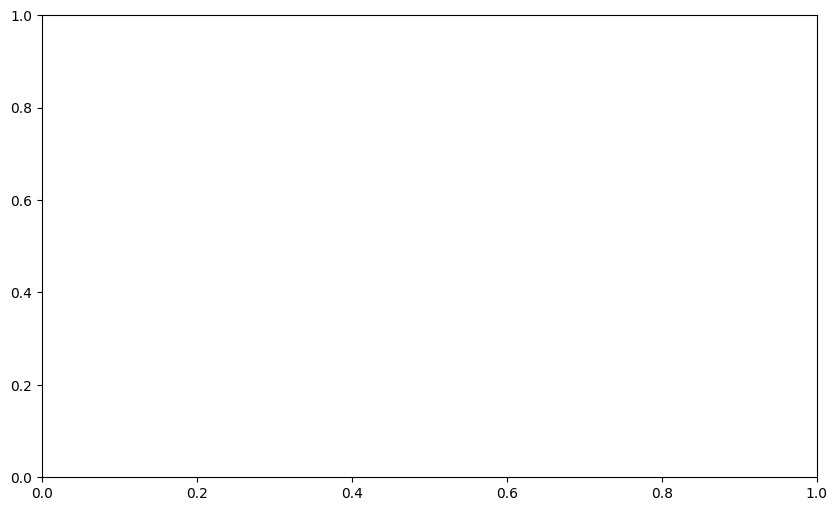

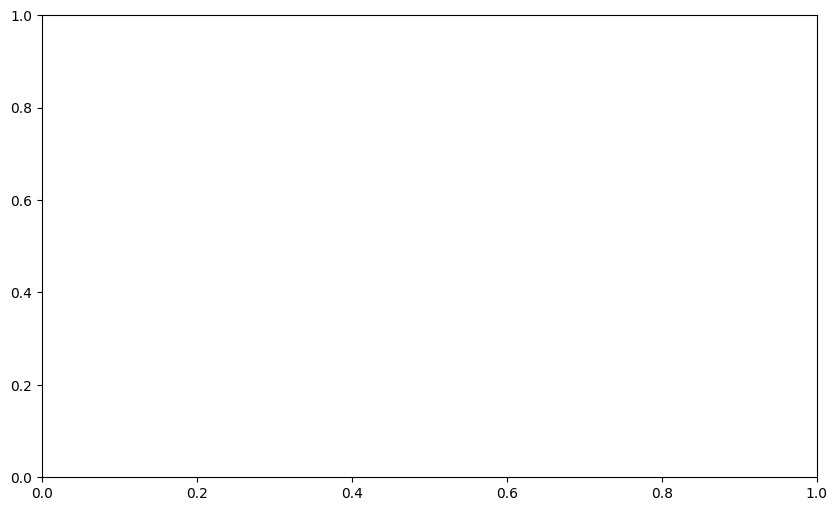

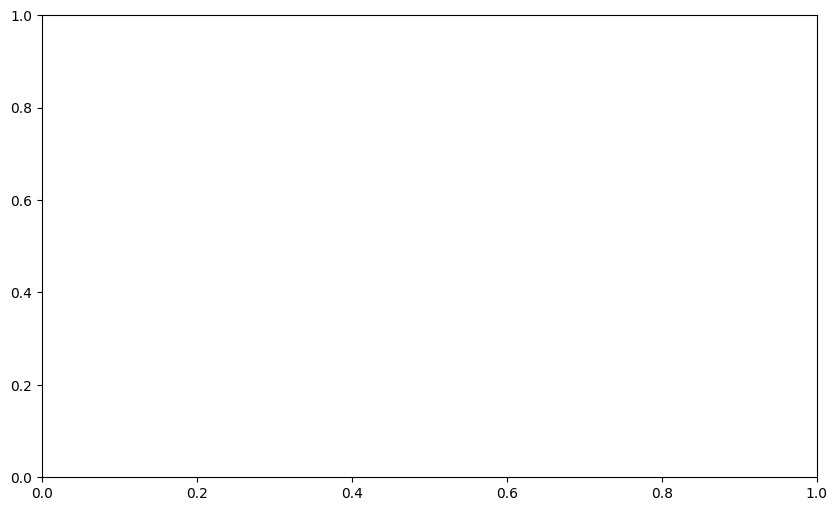

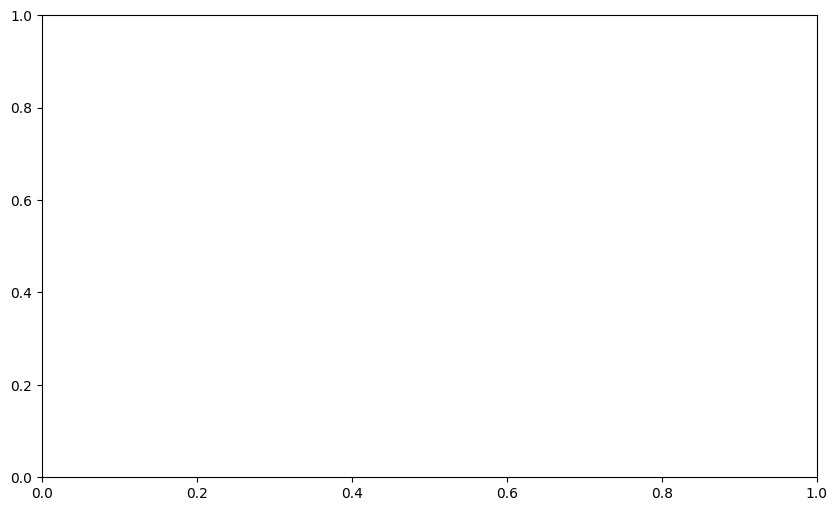

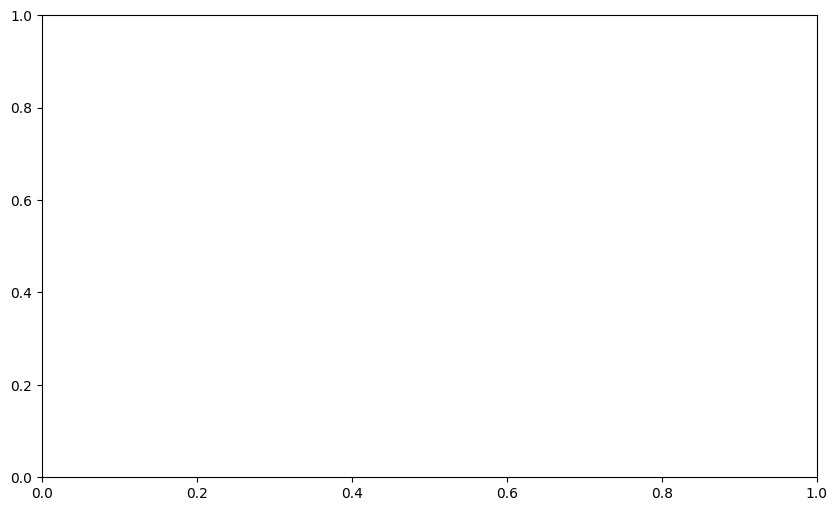

In [ ]:
# tests= ["schema_based_materialization", "load_based_t0.3", "load_based_t0.35", "load_based_t0.4", "load_based_t0.45"]

# # Filter the DataFrame for the tests in the current group.
# df_current = meta_results[meta_results["Test"].isin(tests)].copy()

# # Create a new column for combination (Query proportion / Majority proportion)
# df_current["combination"] = df_current["Query proportion"].astype(str) + "/" + df_current["Majority proportion"].astype(str)

# run_ids = sorted(df_current["Load"].unique())

# # Get all unique combination groups (sorted for consistent x-axis ordering)
# combinations_sorted = sorted(df_current["combination"].unique())
# x_positions = np.arange(len(combinations_sorted))

# count = 0
# for run in run_ids:
#     fig, ax = plt.subplots(figsize=(10, 6))

#     for idx, comb in enumerate(combinations_sorted):
#         if count == 4:
#             df_cr = df_current[(df_current["combination"] == comb) & (df_current["Load"] == run)]
#             print(df_cr)
#         count += 1
        
# print(count)










